In [76]:
import pandas as pd
import json
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [77]:
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [78]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
repository = '/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD/'
%cd {repository} 
%ls -a

/content/drive/MyDrive/MyDocuments/Academic/Education after grad/UCB/IEOR 2019/Academics/Capstone/Project/Git/DemandPredictionJD
 capstone_jd_msom_data-minus-click-data/
'Clustering with K-prototype .ipynb'
 .git/
 initial_data_cleaning_order.ipynb
 Inventory_optimization.ipynb
 .ipynb_checkpoints/
'OLS models - Lei.ipynb'
 order_after_engineer.csv
 order_aggregation_Lei.ipynb
 order_dict.json
 PyTorch_models_Ben.ipynb
 README.md
 sku_clustering.csv
 sku_with_cluster.csv
 warehouse_capacity_preprocessing.ipynb


In [80]:
with open('order_dict.json') as f:
    data = json.load(f)

In [81]:
order_dict = {int(k):pd.DataFrame(v).set_index('day_of_month') for k, v in data.items()}

In [82]:
order_dict[1]

,demand,day_of_week,order_hour_mode,order_hour_08,order_hour_95,att1_high,att1_miss,att2_high,att2_miss,type_1_percent,...,fast_promise,original_unit_price_mean,discount_rate_mean,direct_discount_rate_mean,quantity_discount_rate_mean,bundle_discount_mean,gift_mean,dc_ori_mode,dc_ori_num,cluster_id
day_of_month,,,,,,,,,,,,,,,,,,,,,
1,5,3,12,0.000000,1.000000,0.750000,0.250000,0.000000,0.750000,0.000000,...,0.250000,121.475000,0.070538,0.061069,0.009470,0.000000,0.000000,7,1,0
1,18,3,5,0.444444,0.555556,1.000000,0.000000,1.000000,0.000000,1.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,7,1,1
1,57,3,23,0.111111,0.400000,0.488889,0.222222,0.333333,0.355556,0.933333,...,0.888889,108.322222,0.468941,0.104816,0.238231,0.000000,0.044444,7,3,2
1,11,3,14,0.090909,0.636364,1.000000,0.000000,0.545455,0.090909,0.090909,...,0.272727,144.081818,0.669827,0.568953,0.027548,0.000000,0.000000,7,1,3
1,58,3,12,0.111111,0.416667,0.777778,0.083333,0.500000,0.111111,0.333333,...,0.472222,125.488889,0.421472,0.170375,0.178280,0.000000,0.000000,7,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,39,5,14,0.028571,0.742857,0.400000,0.342857,0.628571,0.057143,0.057143,...,0.171429,104.162857,0.335590,0.118868,0.003852,0.013378,0.028571,7,2,6
31,16,5,15,0.000000,0.866667,0.733333,0.200000,0.533333,0.200000,0.000000,...,0.000000,1.200000,0.933333,0.000000,0.000000,0.000000,0.933333,7,1,7
31,26,5,13,0.090909,0.636364,0.590909,0.272727,0.454545,0.272727,0.727273,...,0.727273,111.381818,0.412384,0.084126,NaN,0.039330,0.272727,1,3,8


In [168]:
df = order_dict[1].copy()
df = df.fillna(0)
df.replace(np.inf,0, inplace = True)

# only filter by sigfinicant features
# df = df[['demand','quantity_discount_rate_mean','cluster_id','dc_ori_mode','day_of_week']]
# df = df[['demand','quantity_discount_rate_mean']]
# df

# convert data type for categorical features
df['cluster_id'] = df['cluster_id'].astype('object')
df['dc_ori_mode'] = df['dc_ori_mode'].astype('object')
df['day_of_week'] = df['day_of_week'].astype('object')
# order_hour_mode??

cat = ['cluster_id','dc_ori_mode','day_of_week']
num = df.drop(cat+['demand'], axis = 1).columns
print(num)

Index(['order_hour_mode', 'order_hour_08', 'order_hour_95', 'att1_high',
       'att1_miss', 'att2_high', 'att2_miss', 'type_1_percent', 'no_promise',
       'fast_promise', 'original_unit_price_mean', 'discount_rate_mean',
       'direct_discount_rate_mean', 'quantity_discount_rate_mean',
       'bundle_discount_mean', 'gift_mean', 'dc_ori_num'],
      dtype='object')


In [303]:
# train test split
train = df.query('1<= day_of_month <= 24')
test = df.query('24 < day_of_month <= 31')

train_enc = pd.get_dummies(train, columns = cat)
test_enc = pd.get_dummies(test, columns = cat)

print(train_enc.dtypes)
# print(test_enc.dtypes)

x_train = train_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']].to_numpy()
# x_train = train_enc.drop('demand', axis = 1).to_numpy()
y_train = train_enc['demand'].to_numpy()

x_test = test_enc[['quantity_discount_rate_mean','day_of_week_3','cluster_id_6','cluster_id_7','cluster_id_8','cluster_id_10','dc_ori_num','dc_ori_mode_7']]
# x_test = test_enc.drop('demand', axis = 1)
y_test = test_enc['demand']

# print(x_train)
# print(y_train)
# x_train.float()
# print(list(zip(x_train, y_train)))
print(len(x_train), len(x_test))
# torch.from_numpy(x_train)

demand                           int64
order_hour_mode                  int64
order_hour_08                  float64
order_hour_95                  float64
att1_high                      float64
att1_miss                      float64
att2_high                      float64
att2_miss                      float64
type_1_percent                 float64
no_promise                     float64
fast_promise                   float64
original_unit_price_mean       float64
discount_rate_mean             float64
direct_discount_rate_mean      float64
quantity_discount_rate_mean    float64
bundle_discount_mean           float64
gift_mean                      float64
dc_ori_num                       int64
cluster_id_0                     uint8
cluster_id_1                     uint8
cluster_id_2                     uint8
cluster_id_3                     uint8
cluster_id_4                     uint8
cluster_id_6                     uint8
cluster_id_7                     uint8
cluster_id_8             

In [268]:
# Experiment set
x_train = np.array([[1,2,3,4,5]]).transpose()
y_train = np.array([1,3,2,4,3]).transpose()
print(x_train)
print(y_train)

[[1]
 [2]
 [3]
 [4]
 [5]]
[1 3 2 4 3]


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([198])) that is different to the input size (torch.Size([198, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0, loss 448.8013000488281
epoch 100, loss 353.7474365234375
epoch 200, loss 300.91259765625
epoch 300, loss 275.34893798828125
epoch 400, loss 264.49249267578125
epoch 500, loss 260.14337158203125
epoch 600, loss 258.1391296386719
epoch 700, loss 256.85675048828125
y-intercept  3.482525587081909
Coefficients  [[1.8133011 2.2719204 3.075583  3.3808715 2.6038008 2.844626  2.8163235
  3.731919 ]]
MSE 194.90090777001146
R^2 Score  0.20666530844275754


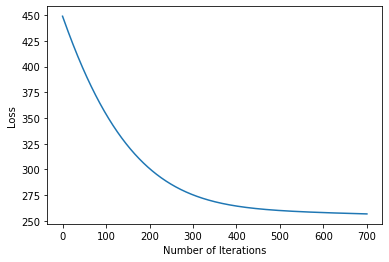

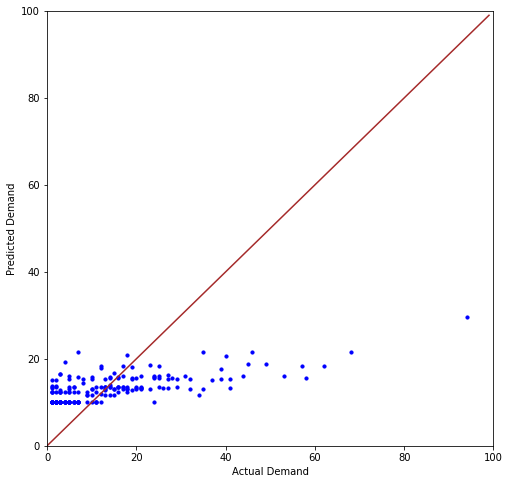

In [385]:
# define model structure
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

# From https://en.wikipedia.org/wiki/Coefficient_of_determination
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2
 
_, inputDim = x_train.shape
# inputDim = len(x_train.columns)     # takes variable 'x' 
outputDim = 1       # takes variable 'y'
learningRate = 0.01
epochs = 701
loss_list = []

model = linearRegression(inputDim, outputDim)
##### For GPU #######
# if torch.cuda.is_available():
#     model.cuda()

# ======================  TODO: replace MSELoss with SPO+ loss                  ========
# initialize the loss (Mean Squared Error) and optimization (Stochastic Gradient Descent)
criterion = torch.nn.MSELoss()                
# criterion = r2_loss
# optimizer = torch.optim.RMSprop(model.parameters(), lr=learningRate)
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)        # SGD is pretty bad with this dataset

# model training

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    # if torch.cuda.is_available():
    #     inputs = Variable(torch.from_numpy(x_train).cuda())
    #     labels = Variable(torch.from_numpy(y_train).cuda())
    # else:
    #     inputs = Variable(torch.from_numpy(x_train))
    #     labels = Variable(torch.from_numpy(y_train))
    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(y_train))

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs.type(torch.FloatTensor))

    # get loss for the predicted output
    loss = criterion(outputs, labels.type(torch.FloatTensor))
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    # store loss
    loss_list.append(loss.data)

    # print loss
    if(epoch % 100 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

plt.plot(range(epochs),loss_list)
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt

# bias b (offset or y-intercept)
print('y-intercept ', model.linear.bias.item())
# weight (w)
print('Coefficients ',  model.linear.weight.detach().numpy())

with torch.no_grad(): # we don't need gradients in the testing phase
    # if torch.cuda.is_available():
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float().cuda())).cpu().data.numpy()
    # else:
    #     pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
    pred_y_train = model(Variable(torch.from_numpy(x_train).float())).data.numpy()
pred_y_train = [pred_y_train[x].item() for x in range(len(pred_y_train))]

# Comparing Actual and predicted values
# print(list(zip(y_train, pred_y_train)))
# dff = {}
# dff['Actual'] = y_train
# dff['Predicted'] = pred_y_train
# dff = pd.DataFrame(dff)
# print(dff)
plt.figure(figsize=(8,8))
plt.scatter(y_train, pred_y_train, c='b', s=10)
plt.xlabel('Actual Demand'), plt.ylabel('Predicted Demand');
lim = 100
x = y = range(lim)
plt.plot(x,y, c='brown')
plt.xlim(0,lim), plt.ylim(0,lim);
plt

# metric = R2Score()
# metric.update([torch.FloatTensor(y_train), torch.FloatTensor(pred_y_train)])
# score = metric.compute()
# print('Ignite R^2 score', score)
from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_train,pred_y_train))
print('R^2 Score ', r2_score(y_true=y_train, y_pred=pred_y_train)) 


In [ ]:
'''
Ref:
Lineary Regression with Pytorch
  https://medium.com/analytics-vidhya/linear-regression-with-pytorch-147fed55f138
  https://linuxhint.com/pytorch_linear_regression_tutorial/
  https://medium.com/biaslyai/pytorch-linear-and-logistic-regression-models-5c5f0da2cb9
  https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817
  https://www.reneshbedre.com/blog/pytorch-regression.html
  https://www.kaggle.com/joseguzman/multiple-regression-explained-with-pytorch?scriptVersionId=73005237
  https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#building-a-linear-regression-model-with-pytorch-gpu
Evaluations
  https://www.analyticsvidhya.com/blog/2021/05/know-the-best-evaluation-metrics-for-your-regression-model/
Quick Ordinary Lineary Regression Calculator
  https://www.socscistatistics.com/tests/regression/default.aspx

'''
